In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [104]:
df = pd.read_csv('Only EW2.csv',parse_dates=True)
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')
df.duplicated()
df = df.set_index('date').asfreq('D')
#df['date'] = pd.to_datetime(df['date'])
#df = df.set_index('date').asfreq('D')
#df.set_index('date').asfreq=('D')

In [105]:
df.head()

,warehouse,total_orders
date,,
2021-09-15,EW2,186
2021-09-16,EW2,199
2021-09-17,EW2,326
2021-09-18,EW2,390
2021-09-19,EW2,353


In [106]:
df[df['total_orders'].isnull()].index.tolist()

[]

<AxesSubplot:xlabel='date'>

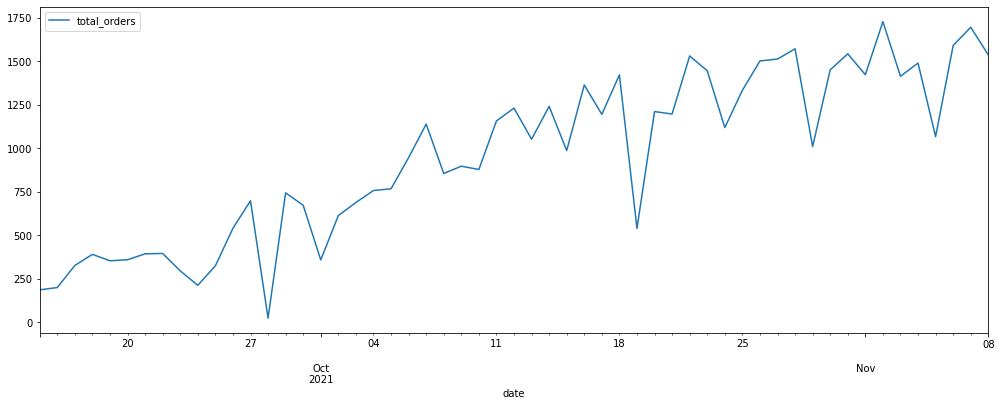

In [107]:
df.plot(figsize=(17,6))

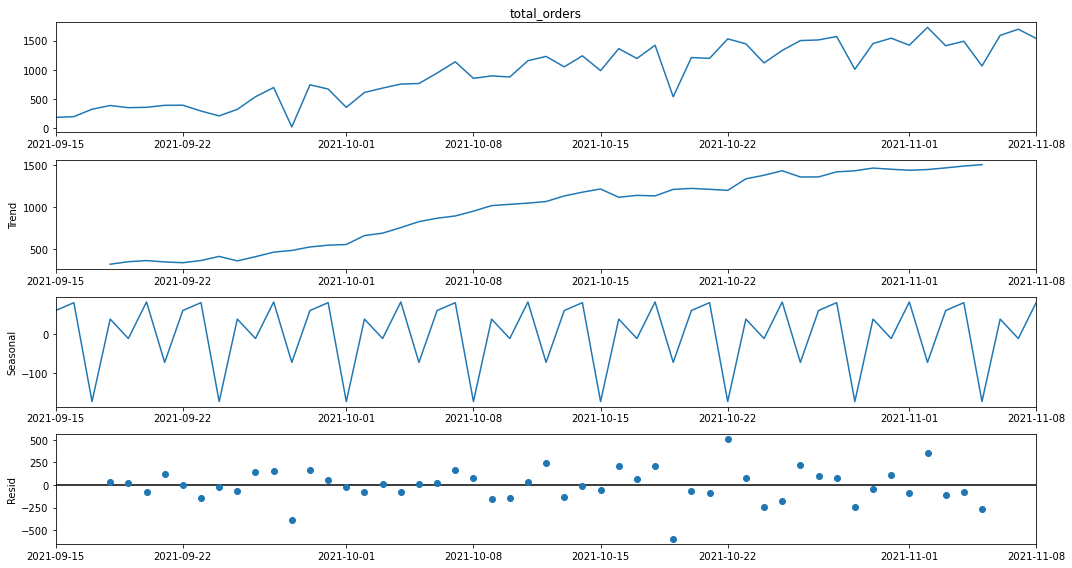

In [108]:
from statsmodels.tsa.seasonal import seasonal_decompose
plt.rcParams['figure.figsize'] = [15, 8]
results = seasonal_decompose(df['total_orders'])
results.plot();

In [109]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [110]:
df.head(),df.tail()

(           warehouse  total_orders
 date                              
 2021-09-15       EW2           186
 2021-09-16       EW2           199
 2021-09-17       EW2           326
 2021-09-18       EW2           390
 2021-09-19       EW2           353,
            warehouse  total_orders
 date                              
 2021-11-04       EW2          1490
 2021-11-05       EW2          1067
 2021-11-06       EW2          1591
 2021-11-07       EW2          1696
 2021-11-08       EW2          1537)

In [111]:
df.drop('warehouse', inplace=True, axis=1)

In [112]:
df.head(),df.tail()

(            total_orders
 date                    
 2021-09-15           186
 2021-09-16           199
 2021-09-17           326
 2021-09-18           390
 2021-09-19           353,
             total_orders
 date                    
 2021-11-04          1490
 2021-11-05          1067
 2021-11-06          1591
 2021-11-07          1696
 2021-11-08          1537)

In [113]:
#divide data into train and test
train_ind = int(len(df)*0.9)
train = df[:train_ind]
test = df[train_ind:]

In [114]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [115]:
scaled_train[:10]

array([[0.09560117],
       [0.10322581],
       [0.17771261],
       [0.21524927],
       [0.19354839],
       [0.19706745],
       [0.2170088 ],
       [0.21818182],
       [0.15953079],
       [0.11085044]])

In [116]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [173]:
# define generator
n_input = int(train_ind*0.1)
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [174]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [175]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
import tensorflow as tf
loss_rmse = [tf.keras.metrics.RootMeanSquaredError(
    name='root_mean_squared_error', dtype=None
)]
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [176]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 100)               40800     
                                                                 
 dense_6 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [177]:
# fit model
model.fit(generator,epochs=50)

Epoch 1/50
45/45 [==============================] - 2s 4ms/step - loss: 0.1358 - mae: 0.3060
Epoch 2/50
45/45 [==============================] - 0s 3ms/step - loss: 0.0258 - mae: 0.1269
Epoch 3/50
45/45 [==============================] - 0s 4ms/step - loss: 0.0235 - mae: 0.1230
Epoch 4/50
45/45 [==============================] - 0s 4ms/step - loss: 0.0200 - mae: 0.1105
Epoch 5/50
45/45 [==============================] - 0s 4ms/step - loss: 0.0248 - mae: 0.1158
Epoch 6/50
45/45 [==============================] - 0s 4ms/step - loss: 0.0191 - mae: 0.1035
Epoch 7/50
45/45 [==============================] - 0s 3ms/step - loss: 0.0216 - mae: 0.1125
Epoch 8/50
45/45 [==============================] - 0s 3ms/step - loss: 0.0227 - mae: 0.1166
Epoch 9/50
45/45 [==============================] - 0s 3ms/step - loss: 0.0198 - mae: 0.1079
Epoch 10/50
45/45 [==============================] - 0s 3ms/step - loss: 0.0204 - mae: 0.1120
Epoch 11/50
45/45 [==============================] - 0s 3ms/step - lo

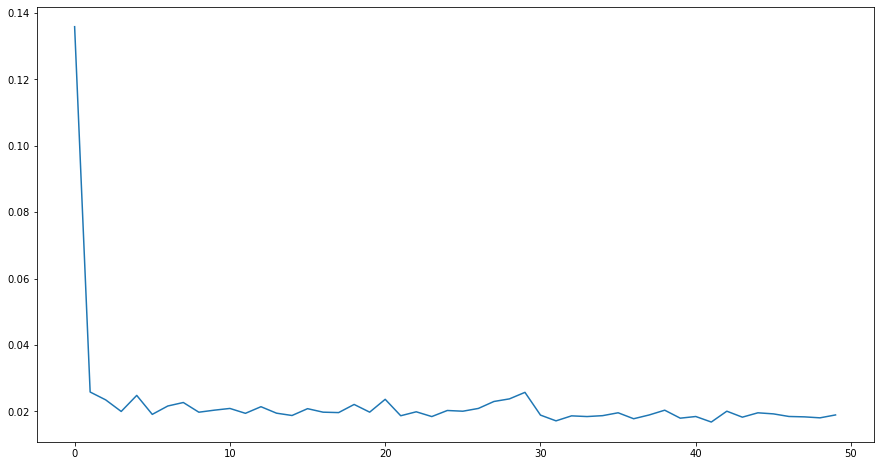

In [178]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [179]:
import tensorflow as tf
tf.keras.metrics.RootMeanSquaredError(
    name='root_mean_squared_error', dtype=None
)

In [180]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [181]:
test_predictions

[array([0.85074747], dtype=float32),
 array([0.8562975], dtype=float32),
 array([0.8485892], dtype=float32),
 array([0.8594708], dtype=float32),
 array([0.82606673], dtype=float32),
 array([0.82176363], dtype=float32)]

In [182]:
test.head()

,total_orders,Predictions
date,,
2021-11-03,1414,1519.646032
2021-11-04,1490,1539.151095
2021-11-05,1067,1559.882477
2021-11-06,1591,1617.770634
2021-11-07,1696,1635.913706


In [183]:
true_predictions = scaler.inverse_transform(test_predictions)
true_predictions

array([[1473.52442968],
       [1482.98722553],
       [1469.84455514],
       [1488.39768785],
       [1431.44377875],
       [1424.10699713]])

In [184]:
predictions=[]
for i in true_predictions:
    predictions.append(i[0])

predictions

[1473.524429678917,
 1482.9872255325317,
 1469.8445551395416,
 1488.3976878523827,
 1431.4437787532806,
 1424.1069971323013]

In [185]:
test['Predictions'] = predictions

C:\Users\shahz\AppData\Local\Temp/ipykernel_12400/897085543.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = predictions


<AxesSubplot:xlabel='date'>

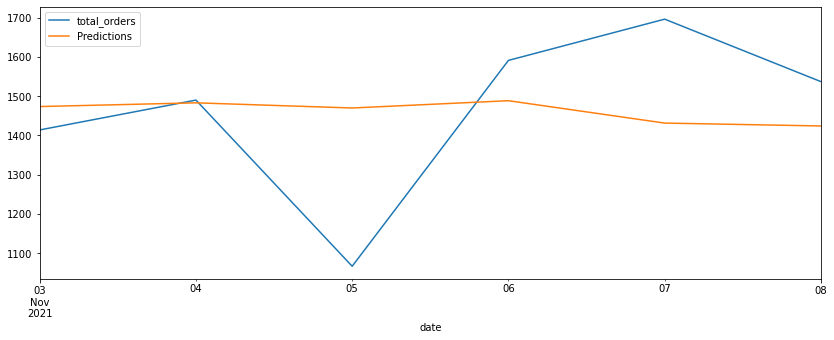

In [186]:
test.plot(figsize=(14,5))

In [187]:
df2 = pd.read_csv('testing_purpose.csv',parse_dates=True)
df2['date'] = pd.to_datetime(df2['date'], format='%d/%m/%Y')
df2 = df2.set_index('date').asfreq('D')

In [188]:
test_casestudy = df2[:]

In [189]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test_casestudy)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [190]:
test_predictions

[array([0.85074747], dtype=float32),
 array([0.8562975], dtype=float32),
 array([0.8485892], dtype=float32),
 array([0.8594708], dtype=float32),
 array([0.82606673], dtype=float32),
 array([0.82176363], dtype=float32),
 array([0.8149705], dtype=float32)]

In [191]:
true_predictions = scaler.inverse_transform(test_predictions)

In [192]:
predictions=[]
for i in true_predictions:
    predictions.append(i[0])

predictions

[1473.524429678917,
 1482.9872255325317,
 1469.8445551395416,
 1488.3976878523827,
 1431.4437787532806,
 1424.1069971323013,
 1412.524691104889]

In [193]:
test_casestudy['Predictions'] = predictions

C:\Users\shahz\AppData\Local\Temp/ipykernel_12400/4089948935.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_casestudy['Predictions'] = predictions


In [196]:
test_casestudy.drop('total_orders', inplace=True, axis=1)
test_casestudy

,Predictions
date,
2021-11-09,1473.524430
2021-11-10,1482.987226
2021-11-11,1469.844555
2021-11-12,1488.397688
2021-11-13,1431.443779
2021-11-14,1424.106997
2021-11-15,1412.524691


In [195]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['total_orders'],test['Predictions']))
print(rmse)

207.8212898521121
